<a href="https://colab.research.google.com/github/ulya1202/NLP/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from wordcloud import WordCloud

In [ ]:
from sklearn.

In [ ]:
import nltk
import spacy

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.4 MB/s eta 0:00:00


In [ ]:
import re
import emoji

In [ ]:
# !python -m spacy download en_core_web_trf

In [ ]:
import spacy
spacy.require_gpu()  # GPU istifadəsini təmin edir
nlp = spacy.load('en_core_web_sm')

## Import Dataset

In [ ]:
!curl -L -o twitter-entity-sentiment-analysis.zip  https://www.kaggle.com/api/v1/datasets/download/jp797498e/twitter-entity-sentiment-analysis

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2041k  100 2041k    0     0  5014k      0 --:--:-- --:--:-- --:--:-- 5014k


In [ ]:
!unzip /content/twitter-entity-sentiment-analysis.zip

Archive:  /content/twitter-entity-sentiment-analysis.zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


In [ ]:
train_data=pd.read_csv('/content/twitter_training.csv')
val_data=pd.read_csv('/content/twitter_validation.csv')
train_data.columns=['id', 'ent', 'sent', 'content']
val_data.columns=['id', 'ent', 'sent', 'content']

In [ ]:
train_data

,id,ent,sent,content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


# Functions

In [ ]:
def remove_more_95_percentile(data,column):
    data_s=data[column].apply(lambda x: len(x.split()))
    return data[(data_s< np.percentile(data_s,95)) &(data_s>7)]

In [ ]:
def clen_text(text):
    #emoji deyish
   text=emoji.demojize(text)
   #emoji sozu elave et
   text=re.sub(r':([a-zA-Z_]+):', ' EMOJI_\1 ', text)
   #punktuasiyani sil
   text=re.sub(r'[^\w\s_]',' ',text)
   #boshluqlari sil
   text=re.sub(r'\s+',' ',text).strip()

   return text

In [ ]:
def find_EMOJ(text):
    emj=re.findall(r'EMOJI_[a-z_]+',text)
    return emj if  emj else None

In [ ]:
def lem(text):
    doc=nlp(text)
    return ' '.join([wor.lemma_ for wor in doc if not wor.is_stop ])

In [ ]:
def dataset_c(x,y):
    train_data=tf.data.Dataset.from_tensor_slices((x,y))
    train_data=train_data.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return train_data


# EDA

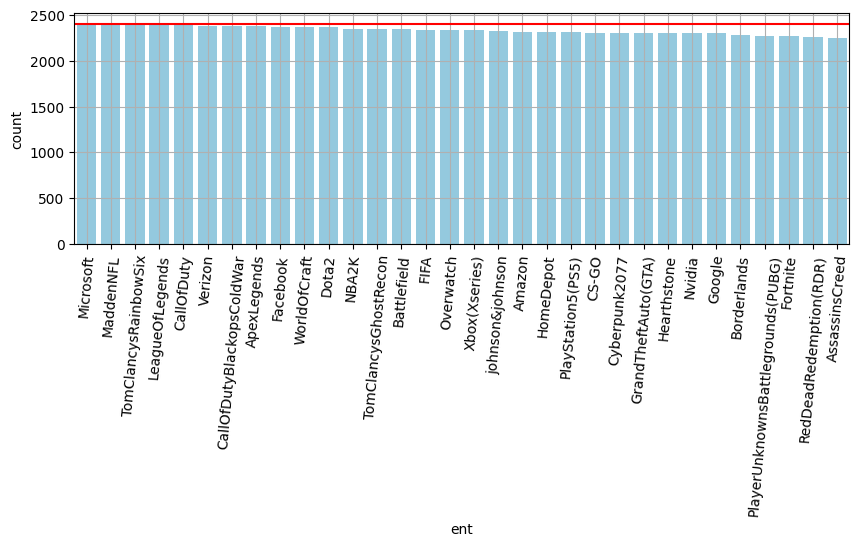

In [ ]:
plt.figure(figsize=(10,3))
sns.barplot(train_data['ent'].value_counts(), color='skyblue')
plt.xticks(rotation=85)
plt.grid()
plt.axhline(train_data['ent'].value_counts().max(), color='red');

In [ ]:
our_train_data=train_data[['content','sent']]


In [ ]:
our_train_data.isnull().sum()

,0
content,686
sent,0


In [ ]:
our_train_data=our_train_data.dropna()

In [ ]:
our_train_data.isnull().sum()

,0
content,0
sent,0


In [ ]:
our_train_data.duplicated().sum()

np.int64(4227)

In [ ]:
our_train_data=our_train_data.drop_duplicates()

In [ ]:
#neki hem 4 -une de labellenib silirem , umid eedirem duz gerar idi
#eyni komente niye hem irrelevant hem positive hem neytral verilsin ki anlamadim???
our_train_data.describe(include='O')

,content,sent
count,69768,69768
unique,69490,4
top,by,Negative
freq,4,21237


In [ ]:
all_4=our_train_data['content'].value_counts()[our_train_data['content'].value_counts()>1]
without_4=our_train_data.drop(our_train_data[our_train_data['content'].isin(all_4.index) ].index)


In [ ]:
without_4.describe()

,content,sent
count,69353,69353
unique,69353,4
top,Just like the windows partition of my Mac is l...,Negative
freq,1,21135


In [ ]:
# space=our_train_data['content'].value_counts().head(1)
# neew=train_data.drop(train_data[train_data['content']==space.index[0]].index )
# neew.describe(include='O')


In [ ]:
# without_4[without_4['content']==without_4['content'].value_counts().head(1).index[0]]

In [ ]:
without_4['sent'].value_counts()

,count
sent,
Negative,21135
Positive,19024
Neutral,17000
Irrelevant,12194


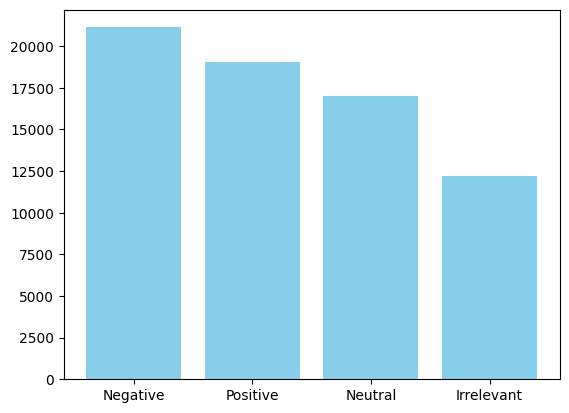

In [ ]:
plt.bar(height=without_4['sent'].value_counts(), x=without_4['sent'].value_counts().index , color='skyblue');

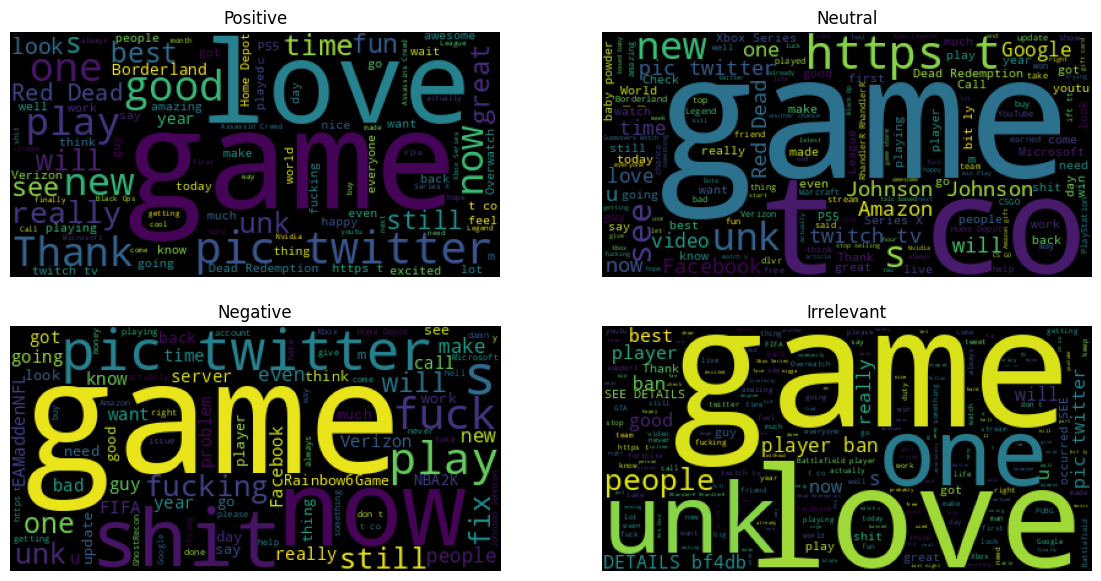

In [ ]:
plt.figure(figsize=(14,7))
for i,content in enumerate(without_4['sent'].unique()):
    world_c=WordCloud().generate(''.join([i for i in without_4[without_4['sent']==content]['content']]))
    plt.subplot(int(np.ceil(len(without_4['sent'].unique())**0.5)),int(np.ceil(len(without_4['sent'].unique())**0.5)),i+1)
    plt.title(f'{content}')
    plt.imshow(world_c)
    plt.axis('off');

# Preprocessing

## clean text from unnecesary symbols

In [ ]:
without_4['content']=without_4['content'].apply(clen_text)

## reduce by frequency

In [ ]:
w_4=without_4['content'].apply(lambda x: x.split())
length=w_4.apply(len)
leng_c=length.value_counts()

In [ ]:
x=leng_c.index
y=leng_c.values

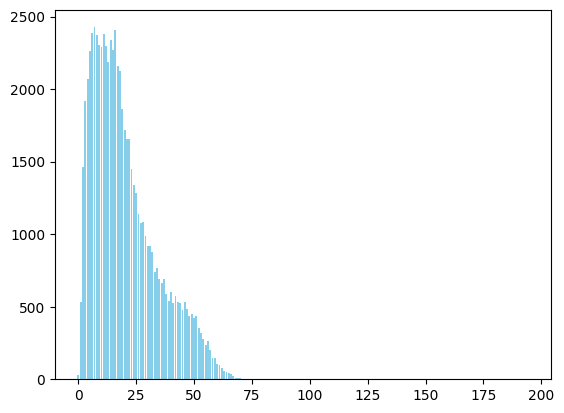

In [ ]:
plt.bar(x,height=y, color='skyblue');

In [ ]:
np.percentile(length,95)

np.float64(49.0)

In [ ]:
without_5=remove_more_95_percentile(without_4,'content')

In [ ]:
without_5['content'].apply(find_EMOJ).isna().sum()

np.int64(52467)

## Lemantization

In [ ]:
without_5['content']=without_5['content'].apply(lem)

<ipython-input-42-2fb18fc90141>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  without_5['content']=without_5['content'].apply(lem)


In [ ]:
without_5['content'].apply(lambda x: len(x.split())).value_counts()

,count
content,
7,3764
8,3739
9,3736
6,3562
10,3461
11,3270
12,3248
13,2883
5,2807


In [ ]:
without_5['content']

,content
0,come border kill
1,m get borderland kill
2,m come borderland murder
3,m get borderland 2 murder
4,m get borderland murder
...,...
74676,realize Windows partition Mac like 6 year Nvid...
74677,realize Mac window partition 6 year Nvidia dri...
74678,realize window partition Mac 6 year Nvidia dri...
74679,realize window partition Mac like 6 year Nvidi...


In [ ]:
dub_idx=without_5[without_5['content'].duplicated()].index
without_6=without_5.drop(dub_idx, axis=0)

## Dataset

# Model

2. 🧹 Preprocessing (Təmizləmə)
Lowercase

Punctuation sil

Stopword removal

Lemmatization (əgər klassik modeldirsə)

Emoji/reminder silmək (əgər sosial mediadırsa)
3. 🔤 Tokenization və Embedding

➡️ Option 1 (Basic): Tokenizer və Embedding Layer (Keras ilə)

➡️ Option 2 (Advanced): Pretrained embeddings (GloVe, FastText)

➡️ Option 3 (Pro Level): Transformers (BERT, RoBERTa)
4. 🧠 Model Qurulması (RNN | BiLSTM | Attention)
✅ Ən heyrətamiz olan kombinasiya: BiLSTM + Attention Layer

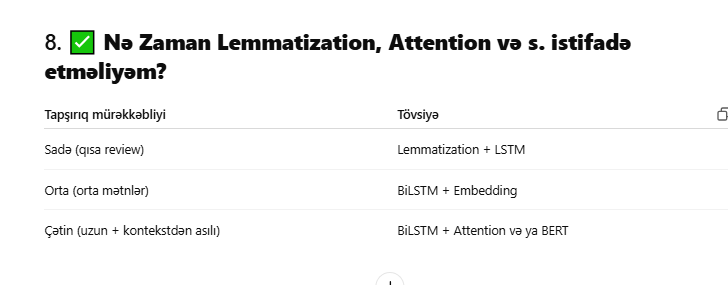

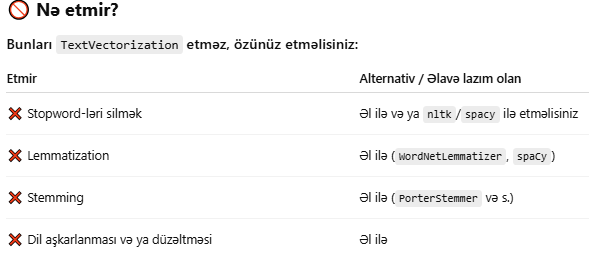

# m

In [ ]:
x=without_6['content']
y=without_6['sent']
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(y)

train_data=dataset_c(x,y)

In [ ]:
x_val=val_data['content']
y_val=val_data['sent']
y_val=label_encoder.transform(y_val)
val_dat=dataset_c(x_val,y_val)

In [ ]:
vocab_size=10_000

text_v=tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=100,
    pad_to_max_tokens=True,
    encoding='utf-8',


)


text_v.adapt(x)

text_v.get_vocabulary()[:100]


['',
 '[UNK]',
 np.str_('t'),
 np.str_('s'),
 np.str_('com'),
 np.str_('game'),
 np.str_('play'),
 np.str_('m'),
 np.str_('good'),
 np.str_('like'),
 np.str_('2'),
 np.str_('get'),
 np.str_('pic'),
 np.str_('twitter'),
 np.str_('johnson'),
 np.str_('new'),
 np.str_('love'),
 np.str_('go'),
 np.str_('time'),
 np.str_('unk'),
 np.str_('3'),
 np.str_('player'),
 np.str_('co'),
 np.str_('look'),
 np.str_('people'),
 np.str_('facebook'),
 np.str_('thank'),
 np.str_('fuck'),
 np.str_('shit'),
 np.str_('https'),
 np.str_('amazon'),
 np.str_('great'),
 np.str_('don'),
 np.str_('google'),
 np.str_('win'),
 np.str_('ban'),
 np.str_('year'),
 np.str_('microsoft'),
 np.str_('bad'),
 np.str_('xbox'),
 np.str_('day'),
 np.str_('1'),
 np.str_('4'),
 np.str_('come'),
 np.str_('ve'),
 np.str_('know'),
 np.str_('work'),
 np.str_('dead'),
 np.str_('5'),
 np.str_('verizon'),
 np.str_('k'),
 np.str_('watch'),
 np.str_('want'),
 np.str_('think'),
 np.str_('rhandlerr'),
 np.str_('red'),
 np.str_('fifa'),
 np

In [ ]:
embed_size=300
model=tf.keras.Sequential([
    text_v,
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512)), # return_state=True
    tf.keras.layers.Dense(4,activation='softmax', kernel_initializer='glorot_normal')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer= tf.keras.optimizers.Nadam(learning_rate=1e-3),
    metrics = ['accuracy']
)



model.fit(train_data, validation_data=val_dat, epochs=50, batch_size=32)

Epoch 1/50
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.7377 - loss: 0.6946 - val_accuracy: 0.4795 - val_loss: 1.3401
Epoch 2/50
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8994 - loss: 0.2885 - val_accuracy: 0.4865 - val_loss: 1.6482
Epoch 3/50
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9477 - loss: 0.1549 - val_accuracy: 0.5696 - val_loss: 1.4567
Epoch 4/50
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9645 - loss: 0.1015 - val_accuracy: 0.5676 - val_loss: 1.8180
Epoch 5/50
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9722 - loss: 0.0794 - val_accuracy: 0.5746 - val_loss: 1.8646
Epoch 6/50
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9770 - loss: 0.0651 - val_accuracy: 0.6216 - val_loss: 1.8420
Epoch 7/50
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9804 - loss: 0.0553 - val_accuracy: 0.5926 - val_loss: 2.0734
Epoch 8/50
1511/1511 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9835 -

In [ ]:
#Chat-gpt komek etdi

prediction_data = tf.data.Dataset.from_tensor_slices(np.array(['hello'])).batch(1)
# Get the prediction from the model for the prediction_data
prediction = model.predict(prediction_data)
# Extract the predicted class index using argmax on the prediction output
predicted_class_index = np.argmax(prediction[0])
# Inverse transform the predicted class index to get the predicted label
predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
print(f"Predicted Sentiment: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Sentiment: Negative


In [ ]:


x_val=np.concatenate([x for x,y in val_dat], axis=0)
y_true=np.concatenate([y for x,y in val_dat], axis=0)



In [ ]:
x_val=tf.data.Dataset.from_tensor_slices(x_val).batch(32)

In [ ]:
y_pred=model.predict(x_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step


In [ ]:
# y_pred=np.concatenate([y for y in val_dat], axis=0)
y_pred=np.argmax(y_pred, axis=1)


In [ ]:
original_labels = label_encoder.classes_

<Axes: >

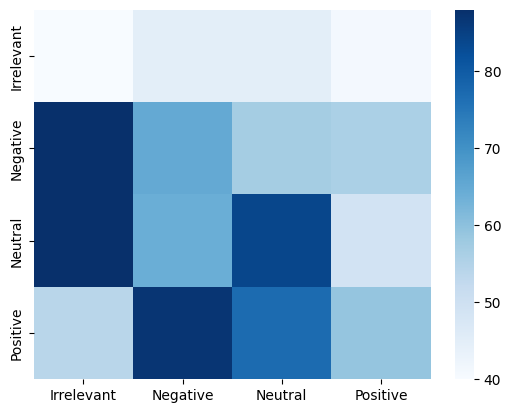

In [ ]:
cm=confusion_matrix(y_true, y_pred)
sns.heatmap(cm,cmap='Blues',xticklabels=original_labels, yticklabels=original_labels);

In [ ]:
print(classification_report(y_true, y_pred, target_names=original_labels))

              precision    recall  f1-score   support

  Irrelevant       0.15      0.23      0.18       171
    Negative       0.25      0.24      0.25       266
     Neutral       0.32      0.29      0.31       285
    Positive       0.29      0.21      0.24       277

    accuracy                           0.25       999
   macro avg       0.25      0.25      0.24       999
weighted avg       0.26      0.25      0.25       999

